In [1]:
from google.colab import drive
drive.mount('/content/drive/')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# !pip install keras-tuner

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense,Dropout,GlobalAveragePooling2D,MaxPooling2D,Flatten,Conv2D,BatchNormalization,Activation
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')



#### Data Preprocessing

In [ ]:
# !unzip /content/drive/MyDrive/facial_expression_recognition/face_populer.zip


In [56]:
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")


# Cek isi direktori tempat dataset diunduh
dataset_path = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
print(os.listdir(dataset_path))


# Ukuran gambar dan batch size

['test', 'train']


In [59]:
# Tentukan direktori untuk train dan validasi
train_dir = os.path.join(dataset_path, "train")
valid_dir = os.path.join(dataset_path, "test")

In [65]:

image_size = (48, 48)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.15
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset="training",
    color_mode = 'grayscale',
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation",
    color_mode = 'grayscale',
    seed=42
)

# Mengecek label
labels = train_generator.class_indices
print(labels)

# Total gambar
total_train_images = train_generator.samples
total_val_images = validation_generator.samples
total_images = total_train_images + total_val_images

print("Total training images:", total_train_images)
print("Total validation images:", total_val_images)
print("Total images in dataset:", total_images)


Found 24406 images belonging to 7 classes.
Found 1073 images belonging to 7 classes.
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Total training images: 24406
Total validation images: 1073
Total images in dataset: 25479


Jumlah gambar per kategori di folder train:
sad: 4830
fear: 4097
happy: 7215
surprise: 3171
angry: 3995
neutral: 4965
disgust: 436

Jumlah gambar per kategori di folder test:
sad: 1247
fear: 1024
happy: 1774
surprise: 831
angry: 958
neutral: 1233
disgust: 111


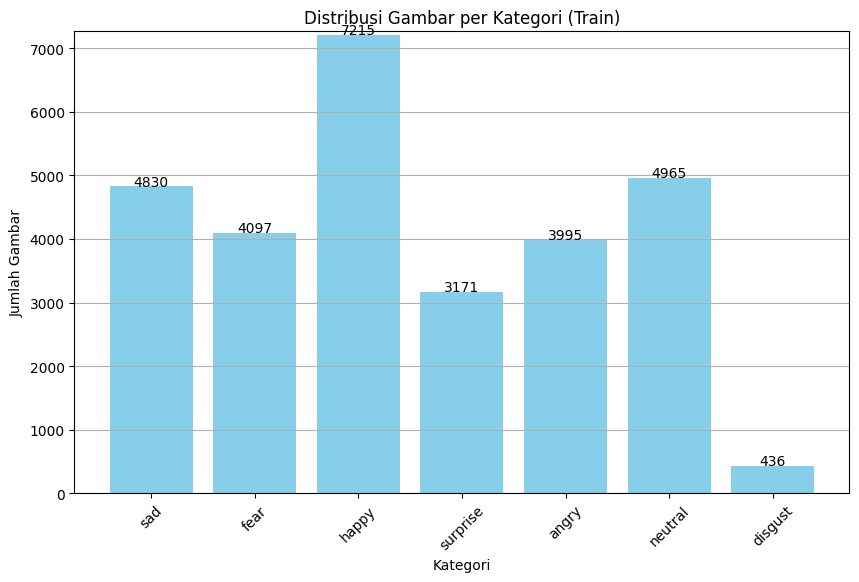

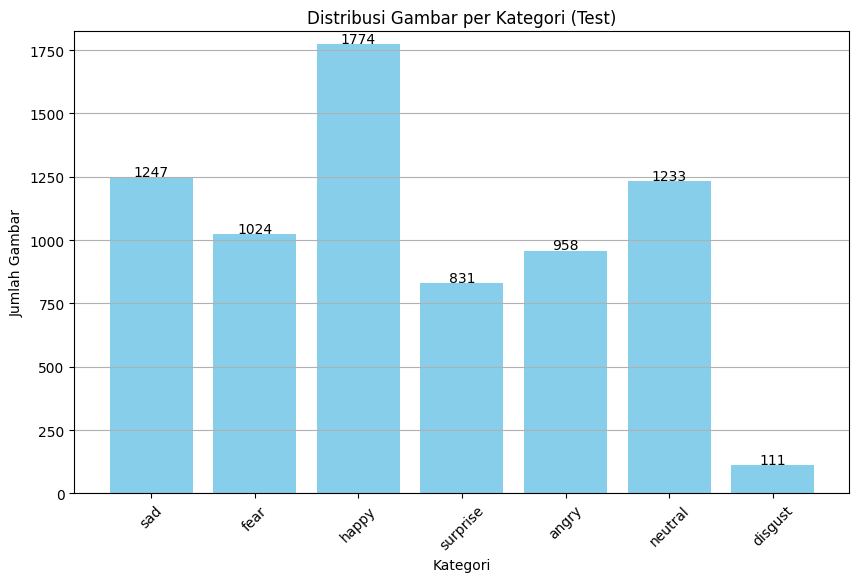

In [66]:

train_dir = train_dir
test_dir  = valid_dir

def count_images_in_directory(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Pastikan ini adalah direktori
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
    return class_counts

# Hitung gambar dalam folder train dan test
train_counts = count_images_in_directory(train_dir)
test_counts = count_images_in_directory(test_dir)

# Tampilkan hasil
print("Jumlah gambar per kategori di folder train:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

print("\nJumlah gambar per kategori di folder test:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count}")

def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Kategori')
    plt.ylabel('Jumlah Gambar')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylim(0, max(counts) + 50)  # Tambah sedikit ruang di atas grafik
    plt.grid(axis='y')

    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center')

    plt.show()

# Tampilkan grafik untuk train dan test
plot_class_distribution(train_counts, "Distribusi Gambar per Kategori (Train)")
plot_class_distribution(test_counts, "Distribusi Gambar per Kategori (Test)")


In [67]:
total_train_images = train_generator.samples
total_val_images = validation_generator.samples
total_images = total_train_images + total_val_images

print("Total training images:", total_train_images)
print("Total validation images:", total_val_images)
print("Total images in dataset:", total_images)


Total training images: 24406
Total validation images: 1073
Total images in dataset: 25479


#### Tampilkan sampel gambar augmented


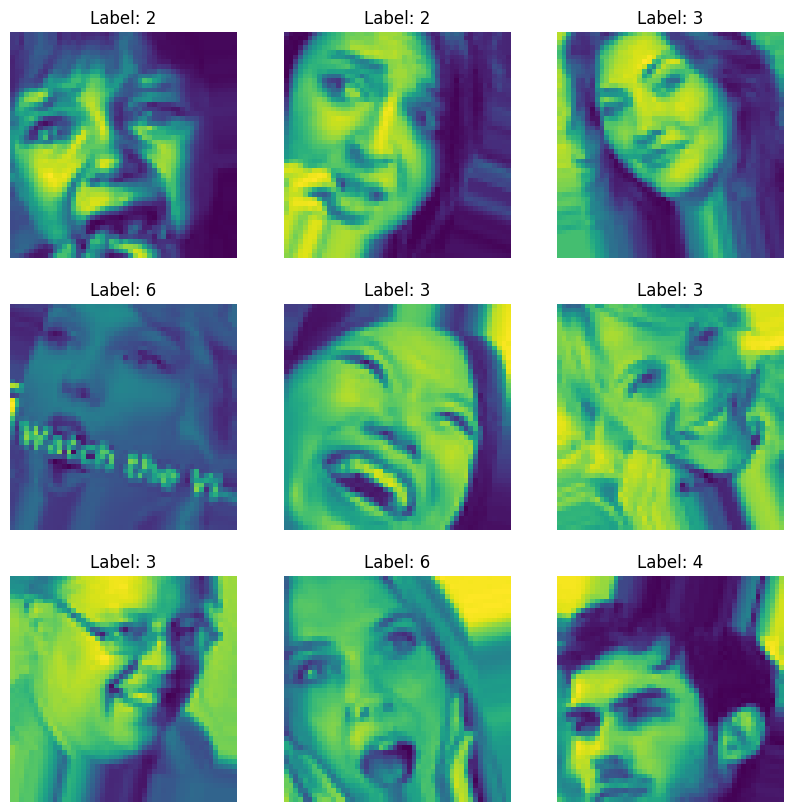

In [68]:
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'Label: {y_batch[i].argmax()}')
    plt.axis('off')
plt.show()


### **Building the CNN Model**

In [82]:

model= tf.keras.models.Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_145 (Conv2D)                  │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_114              │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_64 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_146 (Conv2D)                  │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_115              │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_65 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_147 (Conv2D)                  │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_116              │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_66 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_148 (Conv2D)                  │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_117              │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_67 (MaxPooling2D)      │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_118              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

### **Setting Callbacks**

In [83]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


Epoch 1/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 54s 105ms/step - accuracy: 0.1921 - loss: 2.2870 - val_accuracy: 0.2116 - val_loss: 1.8711 - learning_rate: 0.0010
Epoch 2/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - accuracy: 0.2368 - loss: 1.8929 - val_accuracy: 0.2190 - val_loss: 2.0455 - learning_rate: 0.0010
Epoch 3/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - accuracy: 0.2722 - loss: 1.8048 - val_accuracy: 0.2516 - val_loss: 2.3049 - learning_rate: 0.0010
Epoch 4/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.3350 - loss: 1.6777 - val_accuracy: 0.2898 - val_loss: 2.0654 - learning_rate: 0.0010
Epoch 5/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.4232 - loss: 1.4884 - val_accuracy: 0.4660 - val_loss: 1.4292 - learning_rate: 2.0000e-04
Epoch 6/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - accuracy: 0.4467 - loss: 1.4322 - val_accuracy: 0.4828 - val_loss: 1.3989 - learning_rate: 2.0000e-04
Epoch 7/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0

### **Training Model**

### **Evaluating the Model**

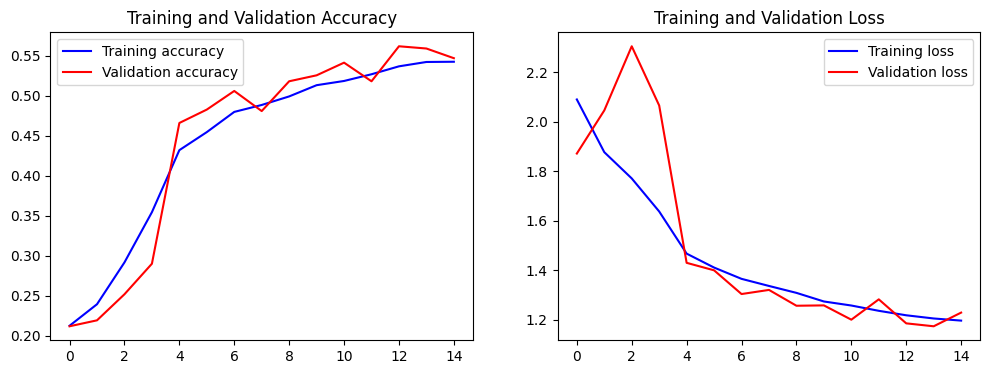

In [84]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()


plot_training_history(history)


In [85]:
model.save('my_best_model.h5')

#### Confusion Matrix dan Classification Report

In [86]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow import keras
best_model = keras.models.load_model('my_best_model.h5')


Y_pred = best_model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=validation_generator.class_indices.keys()))


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.10      0.09      0.09       143
     disgust       0.00      0.00      0.00        16
        fear       0.16      0.06      0.09       153
       happy       0.25      0.24      0.25       266
     neutral       0.16      0.16      0.16       184
         sad       0.18      0.33      0.24       187
    surprise       0.10      0.08      0.09       124

    accuracy                           0.17      1073
   macro avg       0.13      0.14      0.13      1073
weighted avg       0.17      0.17      0.16      1073



### **Final Model Deployment Check**

In [87]:
import time
start = time.time()
pred = best_model.predict(validation_generator)
end = time.time()
print(f'Inference time: {end - start} seconds')


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Inference time: 0.9854891300201416 seconds
